## Game Altering Plays
Sean Steinle

1. [Introduction](#1)
2. [Trimming the DF](#2)
3. [Return Negative Plays](#3)
4. [Return Positive Plays](#4)

<a id='1'>

### Introduction

In determining the value of kickoff returns for the returning team, there are plays that shift field position and there are plays that alter the game. In this notebook, we'll take a deep dive into the latter.

The metrics we'll consider in this notebook are muffs (*isMuff*, *retainsMuff*), fumbles (*isFumble*, *retainsFumble*), and touchdowns (*isTouchdown*). We'll also cut down the dataframe of kickoffs to relevant kickoffs.

<a id='2'>

### Trimming the DF

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

In [33]:
og_df = pd.read_csv("kickoff_dataset.csv")
og_df

Unnamed: 0 kicking_team receiving_team  year  \
0               5          PIT            TEN  2009   
1              15          MIN            CLE  2009   
2              45          NYJ            HOU  2009   
3              47          NYJ            HOU  2009   
4              48          HOU            NYJ  2009   
...           ...          ...            ...   ...   
28310       28310          SEA             SF  2019   
28311       28311           SF            SEA  2019   
28312       28312          SEA             SF  2019   
28313       28313           SF            SEA  2019   
28314       28314          SEA             SF  2019   

                                                    text        kicker  \
0      J.Reed kicks 61 yards from PIT 30 to TEN 9. J....        J.Reed   
1      R.Longwell kicks 66 yards from MIN 30 to CLE 4...    R.Longwell   
2      J.Feely kicks 72 yards from NYJ 30 to HOU -2. ...       J.Feely   
3      J.Feely kicks 71 yards from NYJ 30 to HOU -1. ...       J.Feely   
4      K.Brown kicks 67 yards from HOU 30 to NYJ 3. L...       K.Brown   
...                                                  ...           ...   
28310  J.Myers kicks 65 yards from SEA 35 to end zone...       J.Myers   
28311  M.Wishnowsky kicks 65 yards from SF 35 to end ...  M.Wishnowsky   
28312  J.Myers kicks 65 yards from SEA 35 to end zone...       J.Myers   
28313  M.Wishnowsky kicks 43 yards from SF 35 to SEA ...  M.Wishnowsky   
28314  J.Myers kicks 44 yards from SEA 35 to SF 21. R...       J.Myers   

       isTouchback  isOutOfBounds  isOnside  isFairCatch  ...  isMuff  \
0            False          False     False        False  ...   False   
1            False          False     False        False  ...   False   
2            False          False     False        False  ...   False   
3            False          False     False        False  ...   False   
4            False          False     False        False  ...   False   
...            ...            ...       ...          ...  ...     ...   
28310         True          False     False        False  ...   False   
28311         True          False     False        False  ...   False   
28312         True          False     False        False  ...   False   
28313        False           True     False        False  ...   False   
28314        False          False     False        False  ...    True   

       retainsMuff  isPenalty penalizedPlayer penaltyYards  \
0             True       True        G.McRath           10   
1             True       True        K.Maiava           10   
2             True       True      C.Thompson           10   
3             True       True      C.Thompson           10   
4             True       True     J.Westerman           10   
...            ...        ...             ...          ...   
28310         True      False       no player            0   
28311         True      False       no player            0   
28312         True      False       no player            0   
28313         True      False       no player            0   
28314         True      False       no player            0   

                 penaltyType  penaltySpot  isFumble  retainsFumble  finalSpot  
0          Offensive Holding           72     False           True         82  
1          Offensive Holding           71     False           True         81  
2          Offensive Holding           70     False           True         80  
3      Unnecessary Roughness           80     False           True         90  
4          Offensive Holding           77     False           True         87  
...                      ...          ...       ...            ...        ...  
28310             no penalty            0     False           True        100  
28311             no penalty            0     False           True        100  
28312             no penalty            0     False           True        100  
28313             no penalty       

In [5]:
#isTouchback, isOutOfBounds, isOnside, isFairCatch, isReturned, isTouchdown, isMuff, retainsMuff, isPenalty, isFumble, retainsFumble
touchback = len(df[df["isTouchback"]])/len(df)
print(f"{touchback*100}% of kicks were touchbacks.")

oob = len(df[df["isOutOfBounds"]])/len(df)
print(f"{oob*100}% of kicks were out of bounds.")

fc = len(df[df["isFairCatch"]])/len(df)
print(f"{fc*100}% of kicks were fair catches.")

returned = len(df[df["isReturned"]])/len(df)
print(f"{returned*100}% of kicks were returned.")

td = len(df[df["isTouchdown"]])/len(df)
print(f"{td*100}% of kicks were returned for a touchdown.")

muff = len(df[df["isMuff"]])/len(df)
print(f"{muff*100}% of kicks were muffed.")

cut = df[df["isMuff"]]
rm = len(cut[cut["retainsMuff"]])/len(cut)
print(f"{rm*100}% of isMuffmuffs were retained.")

penalty = len(df[df["isPenalty"]])/len(df)
print(f"{penalty*100}% of kickoffs had an accepted penalty.")

fumble = len(df[df["isFumble"]])/len(df)
print(f"{fumble*100}% of kicks were fumbled.")

cut = df[df["isFumble"]]
rf = len(cut[cut["retainsFumble"]])/len(cut)
print(f"{rf*100}% of fumbles were retained.")

#These numbers look to be about right. One immediate comparison we can do is fumbles lost and muffs kicks vs. touchdowns.

46.40649832244394% of kicks were touchbacks.
1.161928306551298% of kicks were out of bounds.
0.1553946671375596% of kicks were fair catches.
51.66166342927777% of kicks were returned.
0.42733533462828893% of kicks were returned for a touchdown.
0.8935193360409677% of kicks were muffed.
90.11857707509881% of isMuffmuffs were retained.
4.043793042556949% of kickoffs had an accepted penalty.
1.0665724880805227% of kicks were fumbled.
46.35761589403973% of fumbles were retained.


In [6]:
df = df[df["isReturned"]]
len(df)
#this code trims our DF to plays that are returned. if we don't do this, it would make touchdown/fumble numbers look inaccurately
#small. touchdowns don't happen on plays that have touchbacks. neither do fumbles and muffs really. muffs maybe? something to
#think about there... if a player muffs a catch that he wanted to kneel, maybe he has to run it out now. rare case though.

14628

<a id='3'>

### Return Negative Plays

In [44]:
muff = len(df[df["isMuff"]])/len(df)
print(f"{muff*100}% of kicks were muffed.")
cut = df[df["isMuff"]]
rm = len(cut[cut["retainsMuff"]])/len(cut)
print(f"{rm*100}% of muffs were retained.")
muff_loss = (muff*100)*(1-rm)
print(f"{muff_loss}% of returned kicks were muffed and lost.")

fumble = len(df[df["isFumble"]])/len(df)
print(f"{fumble*100}% of kicks were fumbled.")
cut = df[df["isFumble"]]
rf = len(cut[cut["retainsFumble"]])/len(cut)
print(f"{rf*100}% of fumbles were retained.")
fumble_loss = (fumble*100)*(1-rf)
print(f"{fumble_loss}% of returned kicks were fumbled and lost")

print(f"\n{(muff + fumble)*100}% of returned kicks were fumbled or muffed.")
print(f"{muff_loss + fumble_loss}% of returned kicks were lost due to fumble or a muffed catch.")
print(f"That's {(muff_loss/100 + fumble_loss/100)*len(df)} losses of possession for the decade, or {((muff_loss/100 + fumble_loss/100)*len(df))/10} per season.")
print(f"Over the past decade, the mean number of kickoff returns per game for each team is {len(df)/10/16/32}") #kickoff returns per decade/10years/16weeks/32teams = kickoff returns per game for each team
print(f"That means we'd expect a team to lose {(len(df)/10/16/32)*(muff_loss/100 + fumble_loss/100)} possessions per game due to returns.")

#here we're trying to make some general claims about how often very bad things happen on kickoffs

1.4561115668580804% of kicks were muffed.
92.48826291079813% of muffs were retained.
0.10937927262783699% of returned kicks were muffed and lost.
2.057697566311184% of kicks were fumbled.
46.179401993355484% of fumbles were retained.
1.1074651353568497% of returned kicks were fumbled and lost

3.5138091331692642% of returned kicks were fumbled or muffed.
1.2168444079846867% of returned kicks were lost due to fumble or a muffed catch.
That's 177.99999999999997 losses of possession for the decade, or 17.799999999999997 per season.
Over the past decade, the mean number of kickoff returns per game for each team is 2.85703125
That means we'd expect a team to lose 0.034765624999999994 possessions per game due to returns.


In [89]:
bad_df = df[(df["isMuff"] & ~df["retainsMuff"]) | (df["isFumble"] & ~df["retainsFumble"])]
bad_text = list(bad_df["text"])
i=0
for entry in bad_text:
    if "REVERSED" in entry:
        i+=1
        entry
print(i/len(bad_df))
#here we make a new DF that contains all the very bad kickoff plays (some sort of turnover), and find some dirty data we missed

'M.Crosby kicks 62 yards from GB 30 to NYG 8. H.Nicks to NYG 31 for 23 yards (C.Peprah). FUMBLES (C.Peprah), RECOVERED by GB-T.Crabtree at NYG 31. Penalty on NYG-P.Dillard, Offensive Holding, declined. New York Giants challenged the fumble ruling, and the play was REVERSED. M.Crosby kicks 62 yards from GB 30 to NYG 8. H.Nicks to NYG 31 for 23 yards (C.Peprah). PENALTY on NYG-P.Dillard, Offensive Holding, 10 yards, enforced at NYG 22.'

'D.Bailey kicks 68 yards from DAL 35 to CLE -3. J.Cribbs to CLE 25 for 28 yards (D.McCray). FUMBLES (D.McCray), RECOVERED by DAL-E.Sims at CLE 26. Penalty on CLE-A.Smith, Offensive Holding, declined. Cleveland challenged the fumble ruling, and the play was REVERSED. D.Bailey kicks 68 yards from DAL 35 to CLE -3. J.Cribbs to CLE 14 for 17 yards (D.McCray). PENALTY on CLE-A.Smith, Offensive Holding, 7 yards, enforced at CLE 14.'

'P.McAfee kicks 73 yards from IND 30 to BAL -3. L.Webb to BAL 21 for 24 yards (D.Hall). FUMBLES (D.Hall), RECOVERED by IND-P.McAfee at BAL 21. Baltimore challenged the runner was down by contact ruling, and the play was REVERSED. P.McAfee kicks 73 yards from IND 30 to BAL -3. L.Webb to BAL 21 for 24 yards (D.Hall).'

'O.Mare kicks 72 yards from SEA 30 to SD -2. D.Sproles to SD 22 for 24 yards (K.Chancellor). The Replay Assistant challenged the fumble ruling, and the play was REVERSED. O.Mare kicks 72 yards from SEA 30 to SD -2. D.Sproles to SD 22 for 24 yards (K.Chancellor). FUMBLES (K.Chancellor), RECOVERED by SEA-D.Davis at SD 24. D.Davis to SD 24 for no gain (Claude Spillman).'

'M.Nugent kicks 68 yards from CIN 30 to TB 2. M.Spurlock to TB 26 for 24 yards (R.Muckelroy). Cincinnati challenged the runner was down by contact ruling, and the play was REVERSED. M.Nugent kicks 68 yards from CIN 30 to TB 2. M.Spurlock to TB 26 for 24 yards (R.Muckelroy). FUMBLES (R.Muckelroy), RECOVERED by CIN-A.Jones at TB 29. A.Jones, dead ball declared at TB 29 for no gain.'

'R.Gould kicks 66 yards from CHI 30 to MIN 4. P.Harvin to MIN 29 for 25 yards (C.Graham). FUMBLES (C.Graham), RECOVERED by CHI-C.Graham at MIN 29. C.Graham to MIN 29 for no gain (P.Harvin). MIN-P.Harvin was injured during the play.  Minnesota challenged the fumble ruling, and the play was REVERSED. R.Gould kicks 66 yards from CHI 30 to MIN 4. P.Harvin to MIN 28 for 24 yards (C.Graham). MIN-P.Harvin was injured during the play.'

'N.Folk kicks 62 yards from NYJ 35 to IND 3. L.Brazill to IND 18 for 15 yards (I.Trufant). FUMBLES (I.Trufant), RECOVERED by NYJ-J.Bush at IND 19. J.Bush ran ob at IND 19 for no gain. Play Challenged by Replay Assistant and REVERSED. N.Folk kicks 62 yards from NYJ 35 to IND 3. L.Brazill to IND 18 for 15 yards (I.Trufant).'

'R.Gould kicks 67 yards from CHI 35 to HOU -2. K.Martin to HOU 19 for 21 yards (Z.Bowman). FUMBLES (Z.Bowman), RECOVERED by CHI-B.Costanzo at HOU 19. B.Costanzo to HOU 19 for no gain (K.Martin). Play Challenged by Replay Assistant and REVERSED. R.Gould kicks 67 yards from CHI 35 to HOU -2. K.Martin to HOU 18 for 20 yards (Z.Bowman).'

'J.Tucker kicks 68 yards from BAL 35 to WAS -3. N.Paul to WAS 16 for 19 yards (C.Upshaw). FUMBLES (C.Upshaw), RECOVERED by BAL-D.Reed at WAS 14. D.Reed to WAS 15 for -1 yards (L.Alexander). Play Challenged by Replay Assistant and REVERSED. J.Tucker kicks 68 yards from BAL 35 to WAS -3. N.Paul to WAS 16 for 19 yards (C.Upshaw). FUMBLES (C.Upshaw), ball out of bounds at WAS 15.'

'S.Hauschka kicks 69 yards from SEA 35 to BUF -4. J.Rogers to BUF 24 for 28 yards (H.Farwell). FUMBLES (H.Farwell), RECOVERED by SEA-M.Smith at BUF 23. The Replay Assistant challenged the fumble ruling, and the play was REVERSED. S.Hauschka kicks 69 yards from SEA 35 to BUF -4. J.Rogers to BUF 24 for 28 yards (H.Farwell).'

'S.Hauschka kicks 68 yards from SEA 35 to SF -3. P.Cox to SF 20 for 23 yards (S.Ware; H.Farwell). Seattle challenged the runner was down by contact ruling, and the play was REVERSED. S.Hauschka kicks 68 yards from SEA 35 to SF -3. P.Cox to SF 20 for 23 yards (H.Farwell). FUMBLES (H.Farwell), RECOVERED by SEA-B.Maxwell at SF 20. There was no tackle after fumble recovery.'

'P.McAfee kicks 66 yards from IND 35 to HOU -1. K.Martin to HOU 29 for 30 yards (L.Brazill). FUMBLES (L.Brazill), RECOVERED by IND-D.Reed at HOU 29. D.Reed ran ob at HOU 31 for -2 yards. The Replay Assistant challenged the loose ball recovery ruling, and the play was REVERSED. P.McAfee kicks 66 yards from IND 35 to HOU -1. K.Martin to HOU 28 for 29 yards (L.Brazill). FUMBLES (L.Brazill), ball out of bounds at HOU 28.'

'R.Succop kicks 65 yards from KC 35 to OAK 0. T.Jones to OAK 28 for 28 yards (A.Jenkins). Kansas City challenged the fumble ruling, and the play was REVERSED. R.Succop kicks 65 yards from KC 35 to OAK 0. T.Jones to OAK 29 for 29 yards (J.Martin). FUMBLES (J.Martin), touched at OAK 29, RECOVERED by KC-H.Abdullah at OAK 28. H.Abdullah to OAK 28 for no gain (M.Rivera).'

'J.Feely kicks 64 yards from ARI 35 to SEA 1. R.Turbin to SEA 26 for 25 yards (K.Minter). FUMBLES (K.Minter), RECOVERED by ARI-B.McCann at SEA 24. B.McCann to SEA 24 for no gain (C.Maragos). The Replay Assistant challenged the fumble ruling, and the play was REVERSED. J.Feely kicks 64 yards from ARI 35 to SEA 1. R.Turbin to SEA 26 for 25 yards (K.Minter).'

'N.Novak kicks 69 yards from SD 35 to DEN -4. A.Caldwell to DEN 26 for 30 yards (K.Conner). FUMBLES (K.Conner), RECOVERED by SD-L.Green at DEN 28. L.Green to DEN 28 for no gain (C.Clark). The Replay Official challenged the fumble ruling, and the play was REVERSED. N.Novak kicks 69 yards from SD 35 to DEN -4. A.Caldwell to DEN 26 for 30 yards (A.Gachkar).'

'R.Bullock kicks 67 yards from HOU 35 to CLE -2. M.Moore to CLE 23 for 25 yards (E.Pleasant). FUMBLES (E.Pleasant), RECOVERED by HOU-E.Pleasant at CLE 18. The Replay Official challenged the fumble ruling, and the play was REVERSED. R.Bullock kicks 67 yards from HOU 35 to CLE -2. M.Moore to CLE 23 for 25 yards (E.Pleasant).'

'S.Janikowski kicks 67 yards from OAK 35 to CLE -2. S.Draughn to CLE 17 for 19 yards (T.Mays). FUMBLES (T.Mays), RECOVERED by OAK-A.Holmes at CLE 17. The Replay Official reviewed the runner was down by contact ruling, and the play was REVERSED. S.Janikowski kicks 67 yards from OAK 35 to CLE -2. S.Draughn to CLE 17 for 19 yards (T.Mays).'

'S.Gostkowski kicks 66 yards from NE 35 to HOU -1. C.James to HOU 17 for 18 yards (C.Harbor). New England challenged the runner was down by contact ruling, and the play was REVERSED. S.Gostkowski kicks 66 yards from NE 35 to HOU -1. C.James to HOU 17 for 18 yards (B.Bolden). FUMBLES (B.Bolden), RECOVERED by NE-D.Harmon at HOU 22. D.Harmon to HOU 22 for no gain (A.Dent).'

'M.McCrane kicks 66 yards from OAK 35 to CLE -1. A.Callaway to CLE 23 for 24 yards (K.Wilber). FUMBLES (K.Wilber), RECOVERED by OAK-M.McCrane at CLE 26. M.McCrane to CLE 25 for 1 yard (R.Streater). The Replay Official reviewed the fumble ruling, and the play was REVERSED. M.McCrane kicks 66 yards from OAK 35 to CLE -1. A.Callaway to CLE 23 for 24 yards (K.Wilber; D.Harris).'

'C.Sturgis kicks 60 yards from LAC 35 to SF 5. D.Reed to SF 17 for 12 yards (M.Davis). FUMBLES (M.Davis), RECOVERED by LAC-N.Dzubnar at SF 17. N.Dzubnar to SF 17 for no gain (F.Warner). The Replay Official reviewed the loose ball recovery ruling, and the play was REVERSED. C.Sturgis kicks 60 yards from LAC 35 to SF 5. D.Reed to SF 17 for 12 yards (M.Davis). FUMBLES (M.Davis), ball out of bounds at SF 17.'

'J.Elliott kicks 66 yards from PHI 35 to NYG -1. J.Davis to NYG 25 for 26 yards (J.Mills). FUMBLES (J.Mills), RECOVERED by PHI-J.Adams at NYG 30. J.Adams to NYG 30 for no gain (K.Wynn). The Replay Official reviewed the fumble ruling, and the play was REVERSED. J.Elliott kicks 66 yards from PHI 35 to NYG -1. J.Davis to NYG 25 for 26 yards (J.Mills).'

'S.Gostkowski kicks 60 yards from NE 35 to BUF 5. M.Murphy to BUF 22 for 17 yards (K.Crossen). FUMBLES (K.Crossen), RECOVERED by NE-N.Ebner at BUF 30. N.Ebner to BUF 30 for no gain (D.Lacey). The Replay Official reviewed the fumble ruling, and the play was REVERSED. S.Gostkowski kicks 60 yards from NE 35 to BUF 5. M.Murphy to BUF 22 for 17 yards (N.Grigsby).'

0.12359550561797752


In [92]:
len(bad_df)
bad_df = bad_df[~bad_df["text"].str.contains("REVERSED")]
list(bad_df["text"])
len(bad_df)

156

['O.Mare kicks 70 yards from SEA 30 to STL 0. D.Avery to STL 20 for 20 yards (L.Laury). FUMBLES (L.Laury), RECOVERED by SEA-W.Herring at STL 19. W.Herring to STL 19 for no gain (A.Goldberg).',
 'S.Gostkowski kicks 72 yards from NE 30 to BUF -2. L.McKelvin to BUF 31 for 33 yards (P.Woods). FUMBLES (P.Woods), RECOVERED by NE-S.Gostkowski at BUF 31. S.Gostkowski to BUF 31 for no gain (J.Wendling).',
 'T.Morstead kicks 68 yards from NO 30 to PHI 2. E.Hobbs to PHI 22 for 20 yards (M.Jenkins). FUMBLES (M.Jenkins), RECOVERED by NO-C.Reis at PHI 22. C.Reis to PHI 22 for no gain (E.Buckley).',
 'P.Dawson kicks 72 yards from CLE 30 to DEN -2. P.Hillis to DEN 22 for 24 yards (B.Costanzo). FUMBLES (B.Costanzo), RECOVERED by CLE-B.Costanzo at DEN 22. B.Costanzo to DEN 22 for no gain (L.Jordan).',
 'R.Gould kicks 61 yards from CHI 30 to PIT 9. S.Logan to PIT 31 for 22 yards (J.Williams). FUMBLES (J.Williams), RECOVERED by CHI-C.Steltz at PIT 33. C.Steltz to PIT 33 for no gain (R.Mundy).',
 'L.Tynes 

156

2010    2050
2009    2024
2012    1399
2011    1395
2013    1318
2014    1259
2015    1117
2016    1065
2017    1063
2018     969
2019     969
Name: year, dtype: int64

2013    2667
2012    2608
2015    2605
2018    2601
2016    2597
2019    2587
2014    2573
2011    2558
2010    2531
2017    2507
2009    2481
Name: year, dtype: int64

<AxesSubplot:xlabel='year', ylabel='Count'>

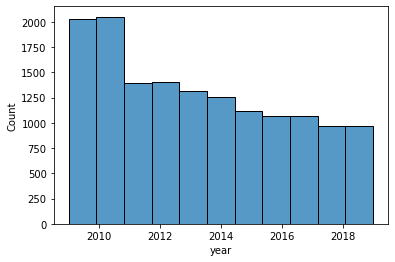

In [43]:
ir_df = og_df[og_df["isReturned"]]
ir_df["year"].value_counts()
og_df["year"].value_counts()
sns.histplot(data=ir_df, x="year", bins=11)

#here we're looking at how returns have changed over time

***Summary***:

These numbers all seem pretty reasonable, but not much analysis can be done in the absence of touchdown and long return data. Note that these numbers seem to say that there is about one loss of possession due to kickoff return in the league every week. Thus, we would say that a team has about a 3.4% chance of losing a possession due to returned kicks per week. Those are about 
the odds that a pregnant woman is carrying twins.

What we can say from this section is that it's absolutely essential to consider the context in regards to time, team, and player when looking at returns. The goal of this notebook is not to definitively say whether big plays on kickoffs are a net positive or negative, but rather to get an idea of the ballpark that turnovers and touchdowns occur at.

Finally, we found a rather large issue when actually looking at the turnover columns themselves: a number of plays that were ruled a fumble and reversed are in this dataset. We'll exclude these and check the rest of the dataset for similar errors. It's particularly worth noting that we may be missing plays that were ruled not a fumble and then were successfully challenged for a fumble.

LEFT TO DO:
    
1. validate turnovers
    - get rid of onsides
    - check existing bad_df texts to confirm
    
    
1a. get a more descriptive understanding of returned kickoffs in general

2. work on positive plays (TDs, long returns)
3. work on yardage game then by team and year